In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (11, 7)

In [41]:
def boxplot(*args, **kwargs):
    labels = kwargs.pop('label', None)
    return sns.boxplot(*args, **kwargs)

In [174]:
financial_features =  ['salary', 'deferral_payments', 'total_payments', 
                       'loan_advances', 'bonus', 'restricted_stock_deferred', 
                       'deferred_income', 'total_stock_value', 'expenses', 
                       'exercised_stock_options', 'other', 'long_term_incentive', 
                       'restricted_stock', 'director_fees']

financial_features.remove('restricted_stock_deferred')
financial_features.remove('director_fees')

email_features =  ['to_messages', 'email_address', 'from_poi_to_this_person', 
                   'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

label = 'poi'

feature_names = financial_features + email_features
feature_names.remove('email_address')

data = pd.read_csv('enron_employees.csv', na_values='NaN')
data = data[data.full_name != 'LAY KENNETH L']

In [137]:
poi_count = len(data[data.poi == True])
non_poi_count = len(data[data.poi == False])

print("Number of POIs:\t\t%d" % poi_count)
print("Number of non-POIs:\t%d" % non_poi_count)
print("Total number:\t\t%d" % (poi_count + non_poi_count))
print("Majority class ratio:\t%f" % (float(non_poi_count) / (poi_count + non_poi_count)))


Number of POIs:		18
Number of non-POIs:	127
Total number:		145
Majority class ratio:	0.875862


In [138]:
def plot_data_presence_map(data):
    data_presence = np.logical_not(np.isnan(data.as_matrix(feature_names))).T.astype(float)
    poi_marker = data.poi.as_matrix().astype(float) + 1
    data_presence = data_presence * poi_marker
    
    plt.figure(figsize=(15, 4))
    g = plt.pcolormesh(data_presence, cmap='PuBu')
    plt.xlim(0, data_presence.shape[1])
    plt.ylim(0, data_presence.shape[0])
    plt.colorbar()

    g.axes.set_yticks(np.arange(len(feature_names)) + 0.5)
    g.axes.set_yticklabels(feature_names);

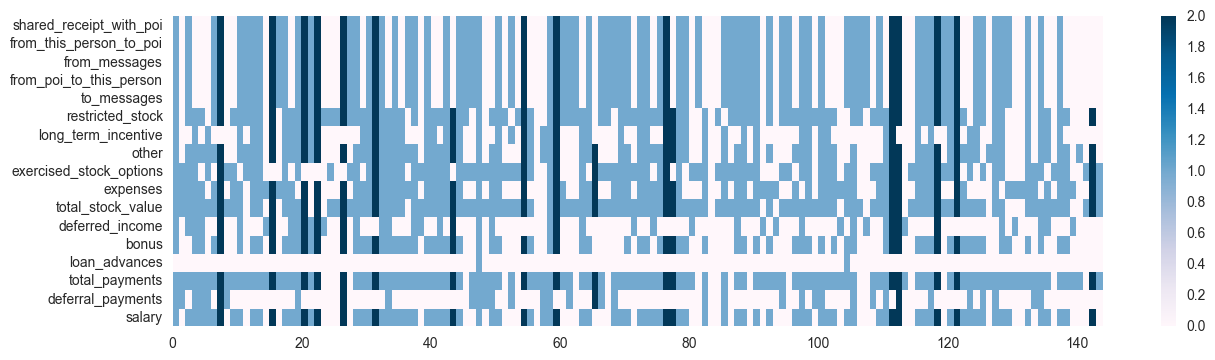

In [102]:
plot_data_presence_map(data)

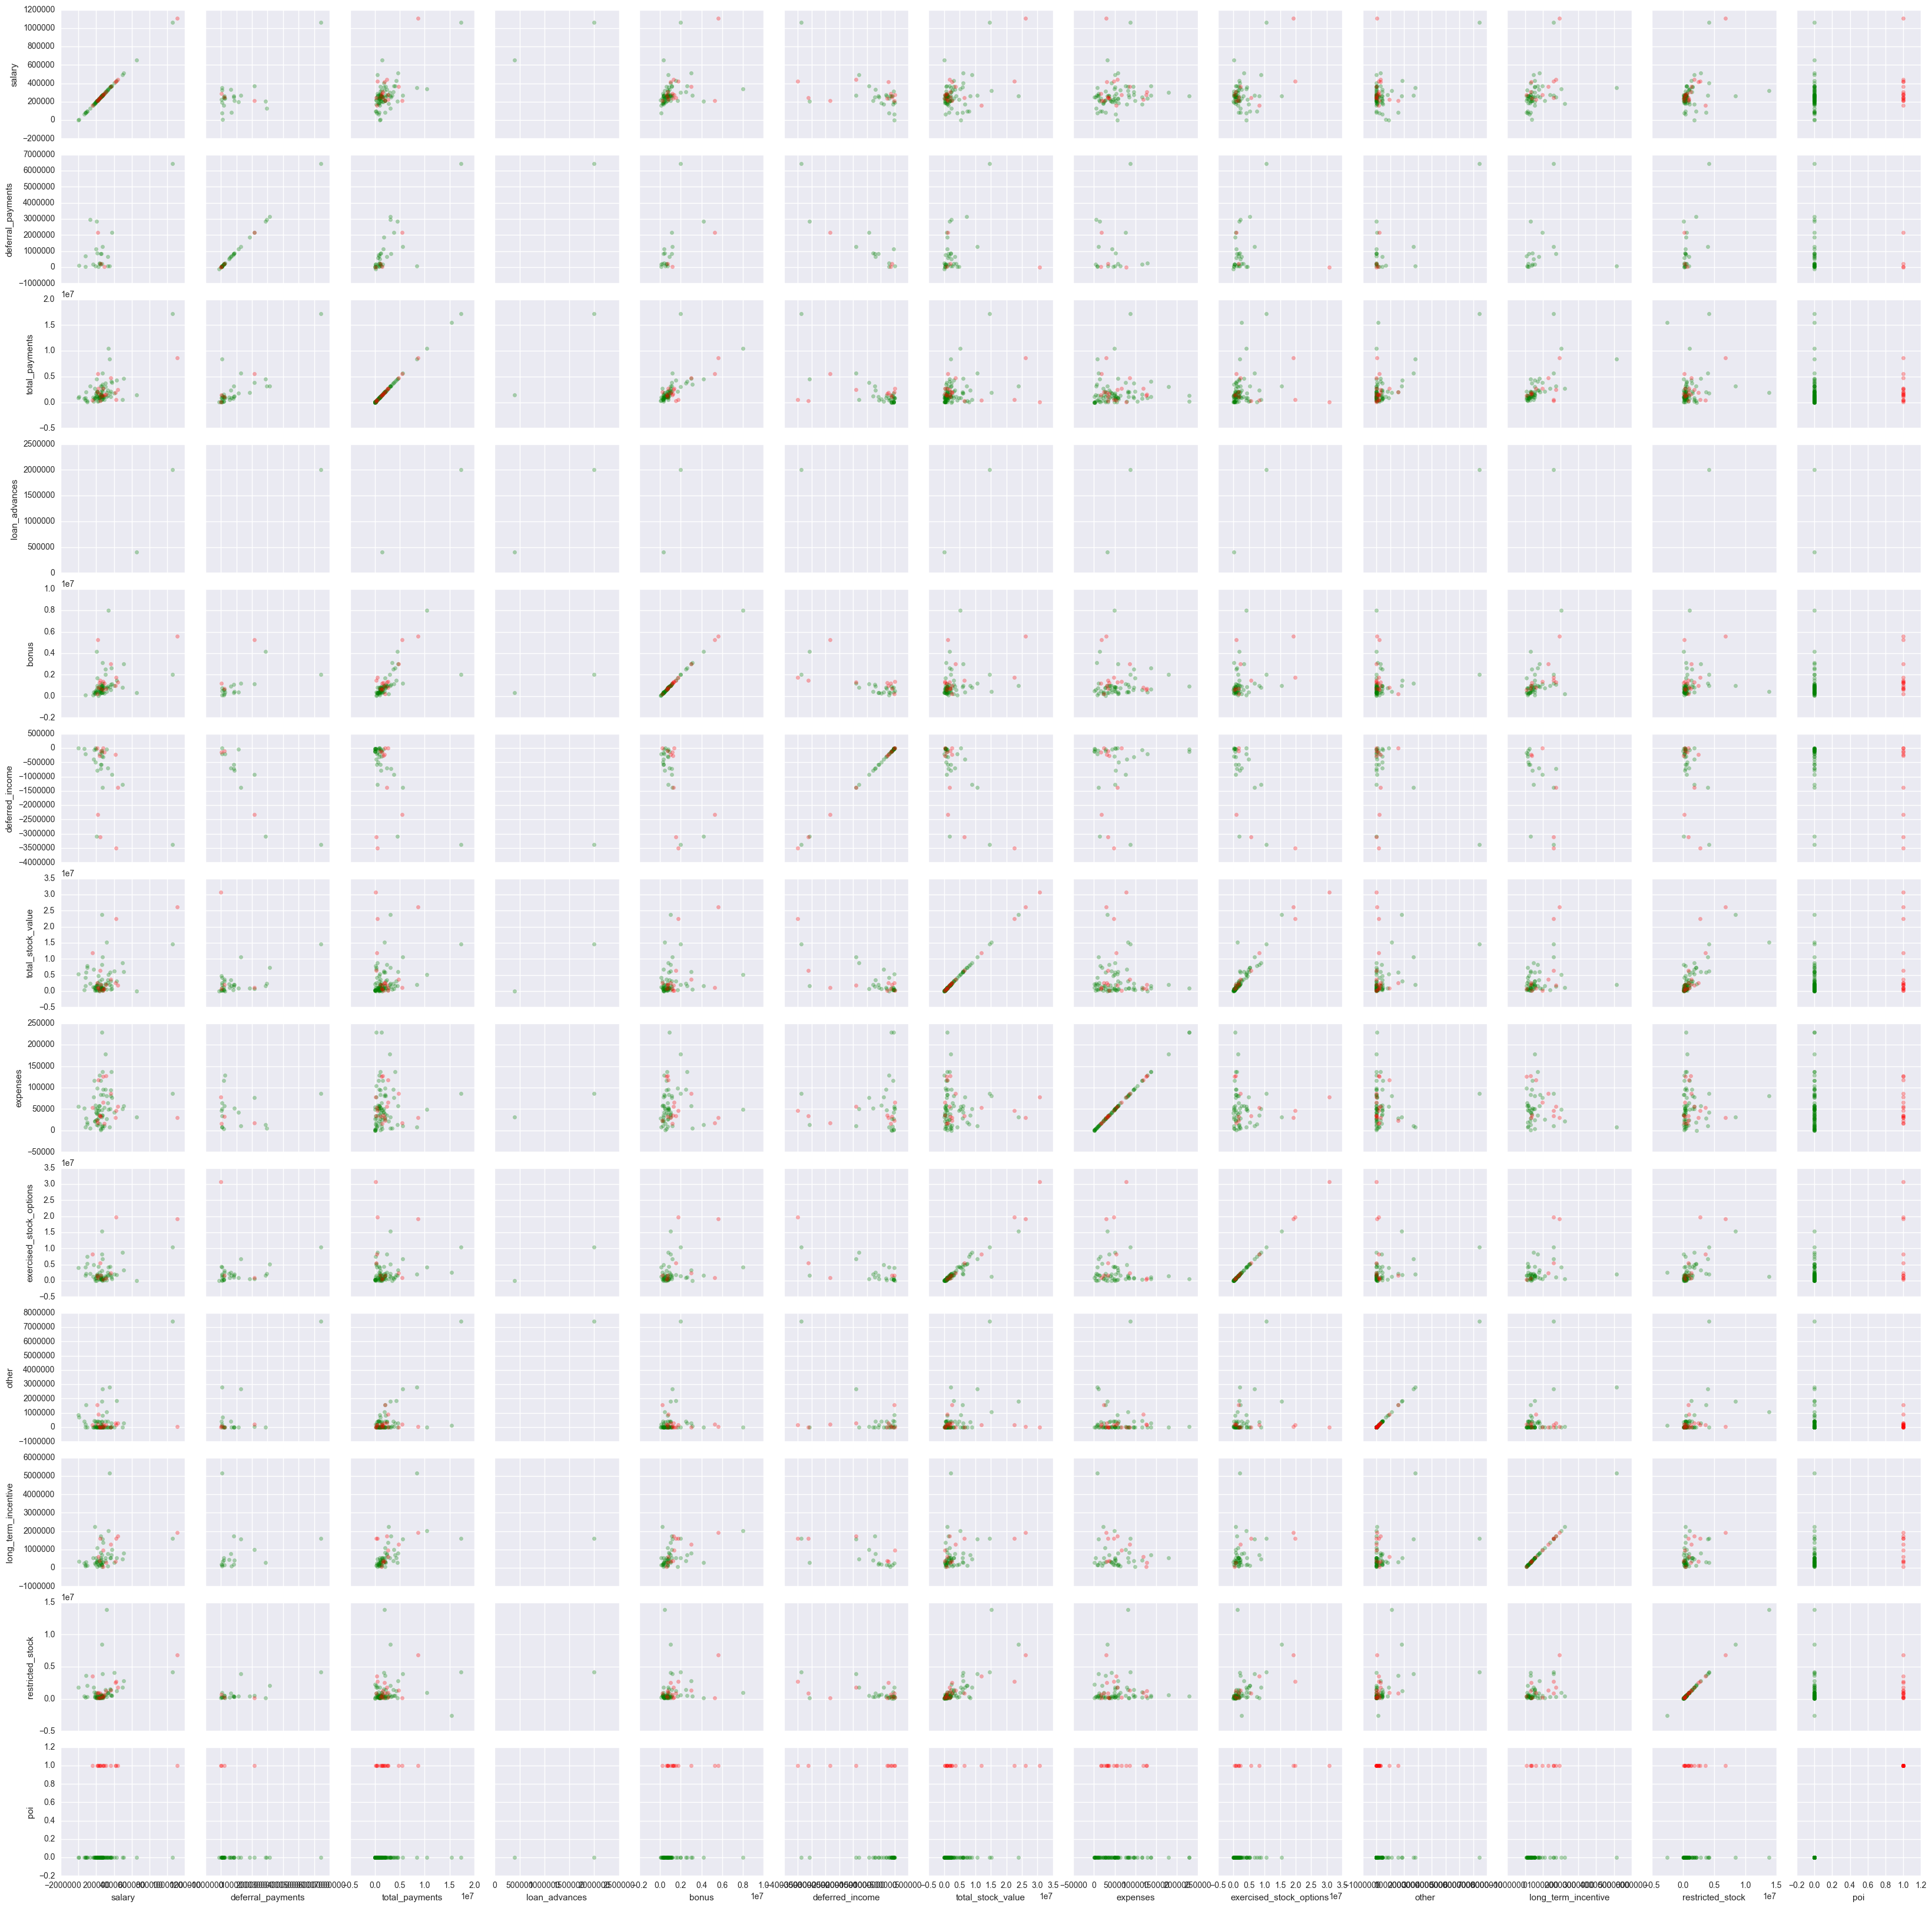

In [103]:
grid = sns.PairGrid(data[financial_features + [label]], hue=label, palette={True: 'red', False: 'green'})
grid.map(plt.scatter, alpha=0.3)

grid.savefig('finance.svg')

In [175]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(Imputer(strategy='mean'), RandomForestClassifier())

In [178]:
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.model_selection import cross_val_score

cv = LeaveOneOut()
acc = cross_val_score(pipeline, data[financial_features], data[label], cv=cv)
print("Accuracy: %0.3f +/- %0.3f" % (acc.mean(), acc.std() * 2))

Accuracy: 0.868 +/- 0.677
